In [1]:
!date

Fri Jan 15 13:31:32 PST 2021


# Compare kallisto-bustools to salmon alevin-alevin fry 

In [63]:
from kb_python.utils import import_matrix_as_anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


def nd(arr):
    return np.asarray(arr).reshape(-1)

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

### Import cellranger barcodes as "ground truth barcodes"

In [286]:
ds = "human-pbmc10k_v3"
ref = "human-grch38"

In [287]:
cellranger_barcodes_file = f"../../data/cellranger_barcodes/{ds}.txt"
cr_barcodes = pd.read_csv(cellranger_barcodes_file, header=None, names=['bcs'])

cr_barcodes = cr_barcodes.bcs.apply(lambda x: x.split('-')[0]).values

cr_barcodes.shape

(11692,)

## Import matrices

In [288]:
alevin_path = f"../../data/alevin_out/{ds}/quant/alevin/"
#alevin_path = "../../data/alevin_out/mouse-SRR8206317_v2/alevin-standard/alevin/"

alevin_raw_decoys = import_matrix_as_anndata(
    barcodes_path=os.path.join(alevin_path, "quants_mat_rows.txt"), 
    genes_path=os.path.join(alevin_path, "quants_mat_cols.txt"), 
    matrix_path=os.path.join(alevin_path, "quants_mat.mtx"))

In [289]:
alevin_raw_decoys

AnnData object with n_obs × n_vars = 1544083 × 33732 

In [290]:
decoys = pd.read_csv(f"../../reference/{ref}/salmon/decoys.txt", header = None, names=['decoys'])

alevin_raw = alevin_raw_decoys[:, ~alevin_raw_decoys.var.index.isin(decoys['decoys'])].copy()

In [291]:
alevin_raw

AnnData object with n_obs × n_vars = 1544083 × 33538 

In [292]:
kb_path = f"../../data/kallisto_out/{ds}/count/"

kb_raw = import_matrix_as_anndata(
    barcodes_path=os.path.join(kb_path, "output.barcodes.txt"), 
    genes_path=   os.path.join(kb_path, "output.genes.txt"), 
    matrix_path=  os.path.join(kb_path, "output.mtx"))

In [293]:
kb_raw

AnnData object with n_obs × n_vars = 1266268 × 33538 

In [294]:
print(kb_raw.var.shape[0] - alevin_raw.var.shape[0])
print(False in kb_raw.var.index == alevin_raw.var.index)

print(kb_raw)
print(alevin_raw)

0
False
AnnData object with n_obs × n_vars = 1266268 × 33538 
AnnData object with n_obs × n_vars = 1544083 × 33538 


## Basic process

In [295]:
def basic_process(A):
    '''
    sum counts per cell
    count ngenes per cell
    filter out cells with zero genes
    '''
    adata = A.copy()
    adata.obs['counts'] = nd(adata.X.sum(axis=1))
    adata.obs['ngenes'] = nd((adata.X > 0).sum(axis=1))
    adata = adata[adata.obs['counts'] > 0]
    adata.layers['log1p'] = np.log1p(adata.X)
    print(adata)

    return adata

In [296]:
kb = basic_process(kb_raw)
alevin = basic_process(alevin_raw)

AnnData object with n_obs × n_vars = 1180076 × 33538 
    obs: 'counts', 'ngenes'
    layers: 'log1p'
AnnData object with n_obs × n_vars = 1544083 × 33538 
    obs: 'counts', 'ngenes'
    layers: 'log1p'


In [297]:
kb_barcodes = kb.obs.index.values
alevin_barcodes = alevin.obs.index.values

common_barcodes = np.intersect1d(kb_barcodes, alevin_barcodes)

# kb_barcodes_only = np.setdiff1d(kb_barcodes,alevin_barcodes)
# alevin_barcodes_only = np.setdiff1d(alevin_barcodes,kb_barcodes)

In [298]:
kb_genes = kb.var.index.values
alevin_genes = alevin.var.index.values

common_genes = np.intersect1d(kb_genes, alevin_genes)

# kb_genes_only = np.setdiff1d(kb_genes,alevin_genes)
# alevin_genes_only = np.setdiff1d(alevin_genes,kb_genes)

### Common matrices

In [299]:
kb_common = kb[common_barcodes][:, common_genes]
alevin_common = alevin[common_barcodes][:, common_genes]

In [300]:
print(kb_common)
print(alevin_common)

View of AnnData object with n_obs × n_vars = 1006143 × 33538 
    obs: 'counts', 'ngenes'
    layers: 'log1p'
View of AnnData object with n_obs × n_vars = 1006143 × 33538 
    obs: 'counts', 'ngenes'
    layers: 'log1p'


In [301]:
kb_common_cr     = kb_common[cr_barcodes]
alevin_common_cr = alevin_common[cr_barcodes]

In [302]:
print(kb_common_cr)
print(alevin_common_cr)

View of AnnData object with n_obs × n_vars = 11692 × 33538 
    obs: 'counts', 'ngenes'
    layers: 'log1p'
View of AnnData object with n_obs × n_vars = 11692 × 33538 
    obs: 'counts', 'ngenes'
    layers: 'log1p'


In [303]:
False in kb_common_cr.obs.index.values == alevin_common_cr.obs.index.values

False

# Generate comparison results

#### MA data

In [168]:
def MA(AX, BX):
    '''
        Computes MA for MA plot
        X: A.var["gene_count"]
        Y: B.var["gene_count"]
    '''
    X = nd(AX.mean(axis=0))
    Y = nd(BX.mean(axis=0))

    M_AB = np.log2(X + 1) - np.log2(Y + 1)
    A_AB = 0.5*(np.log2(X + 1) + np.log2(Y + 1))
    return A_AB, M_AB

In [169]:
A_AB, M_AB = MA(kb_common_cr.X, alevin_common_cr.X)

#### Cell correlation data

In [304]:
# Correlations
def _sparse_M_std(X):
    n = X.shape[0]
    return np.sqrt(n * X.multiply(X).sum(0) - np.multiply(X.sum(0), X.sum(0)))

def sparse_M_corr(X, Y):
    '''
        Computes Pearson correlation between X and Y (both in sparse format). Must be same shape.
        X: A_raw[common_obs.index].layers['log1p'] # raw
        Y: B_raw[common_obs.index].layers['log1p']# raw
        X: A.layers['log1p'] # filtered
        Y: B.layers['log1p'] # filtered
        Notes: I changed the axis in sum and shape, need to check if right
    '''
    X_std = _sparse_M_std(X)
    Y_std = _sparse_M_std(Y)
    XY_std = np.multiply(X_std, Y_std)
    n = X.shape[0]
    XY_cov = n*X.multiply(Y).sum(0) - np.multiply(X.sum(0), Y.sum(0))
    R = np.divide(XY_cov, XY_std)
    return np.squeeze(np.asarray(R))

In [305]:
cc_raw = sparse_M_corr(
    kb_common.layers['log1p'].T, 
    alevin_common.layers['log1p'].T)

In [172]:
cc_filtered = sparse_M_corr(
    kb_common_cr.layers['log1p'].T, 
    alevin_common_cr.layers['log1p'].T)

#### TSVD and TSNE data

In [173]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

def compute_tsvd(X):
    tsvd = TruncatedSVD(n_components=10)
    Y = tsvd.fit_transform(X)
    return Y

def compute_tsne(X):
    tsne = TSNE(perplexity=30, metric="euclidean", n_jobs=10, random_state=42, n_iter=750 )
    Y = tsne.fit_transform(X)
    return Y

In [174]:
kb_common_cr.obsm['TSVD']     = compute_tsvd(kb_common_cr.layers['log1p'])
alevin_common_cr.obsm['TSVD'] = compute_tsvd(alevin_common_cr.layers['log1p'])

In [175]:
kb_common_cr.obsm['TSNE']     = compute_tsne(kb_common_cr.obsm['TSVD'])
alevin_common_cr.obsm['TSNE'] = compute_tsne(alevin_common_cr.obsm['TSVD'])

#### L1 cell-cell distance

In [176]:
from sklearn.metrics.pairwise import manhattan_distances

def l1_dist(X, Y):
    '''
    computes manhattan distance between corresponding cells, and nearest cells
        X: A.layers['log1p']
        Y: B.layers['log1p']
    '''
    dist_AA = manhattan_distances(X, X)
    dist_AB = manhattan_distances(X, Y)

    # nkc are the kallisto-alevin distances
    dist_AB = np.diagonal(dist_AB)

    # ncc are the kallisto-kallisto distances
    AA = []
    for row in dist_AA:
        val = np.partition(row, 1)[1]
        AA.append(val)
    dist_AA = AA

    return dist_AA, dist_AB


In [177]:
dist_AA, dist_AB = l1_dist(kb_common_cr.layers['log1p'], alevin_common_cr.layers['log1p'])
dist_BB, dist_BA = l1_dist(alevin_common_cr.layers['log1p'], kb_common_cr.layers['log1p'])

## Make plots

In [306]:
markersize = 20
alpha=1
linewidth=5
xmax = 10**6

kallisto_color = "#377eb8"
alevin_color = "#dede00"

kallisto_color = "#e41a1c"
alevin_color = '#377eb8'

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

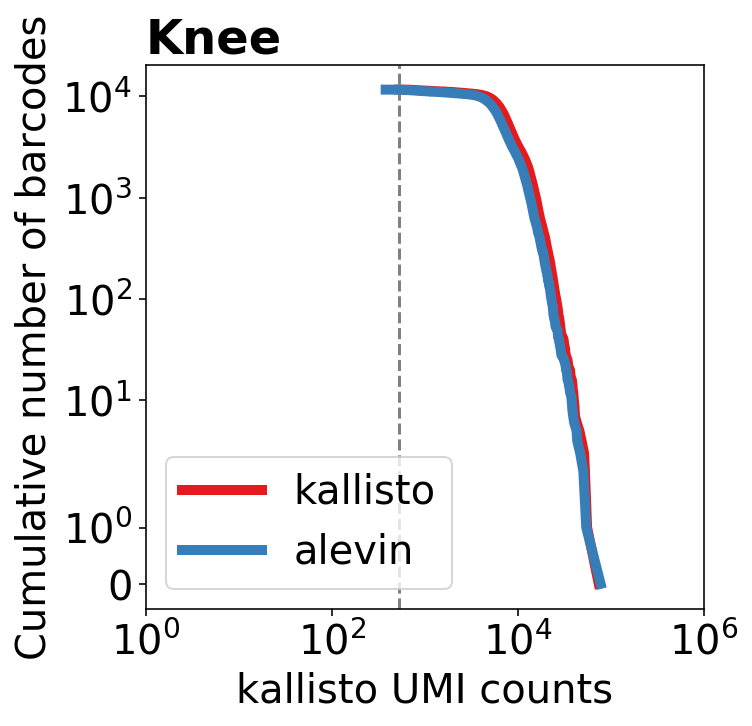

In [307]:
fig, ax = plt.subplots(figsize=(5,5))


x = np.sort(nd(kb_common_cr.X.sum(axis=1)))[::-1]
y = np.arange(x.shape[0])

ax.plot(x, y, color=kallisto_color, label="kallisto", linewidth=linewidth)
cutoff = min(x)
cutoff_mask = x>=cutoff
ax.axvline(x=cutoff, color="grey", linestyle="--")

# ## Alevin
x = np.sort(nd(alevin_common_cr.X.sum(axis=1)))[::-1]
y = np.arange(x.shape[0])

ax.plot(x, y, color = alevin_color, label="alevin", linewidth=linewidth)

ax.set(**{
    'xscale': 'log',
    'xlim': (1, xmax),
    'yscale': 'symlog',
    'xlabel': "kallisto UMI counts",
    'ylabel': "Cumulative number of barcodes"
 })
ax.set_title('Knee', fontweight='bold', loc = 'left' )
ax.legend()

fig.show()

In [308]:
def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

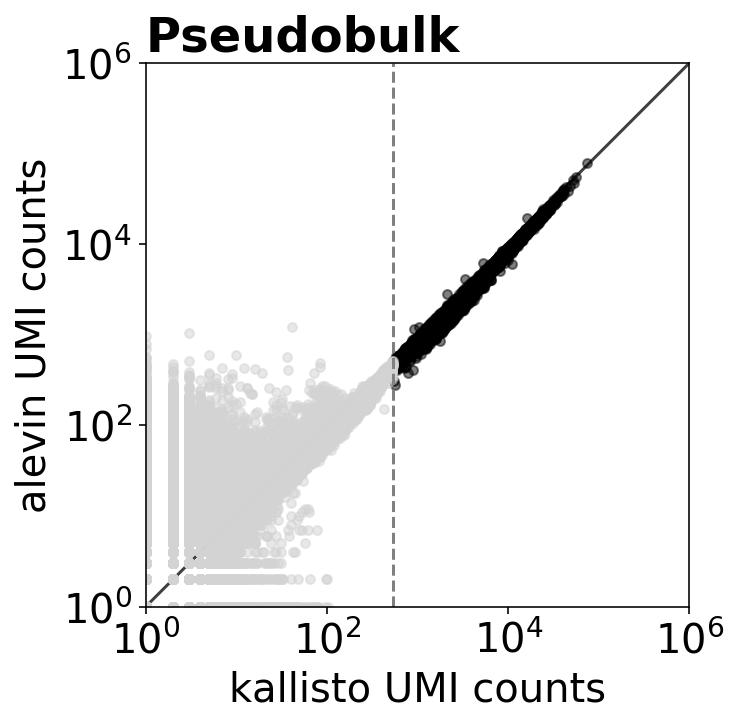

In [309]:
fig, ax = plt.subplots(figsize=(5,5))

x = kb_common.obs['counts'].values
y = alevin_common.obs['counts'].values
cutoff_mask = x>cutoff
xx = x[cutoff_mask]
yy = y[cutoff_mask]
ax.scatter(xx,yy, alpha = alpha-0.5, s=markersize, color="k")

xx = x[~cutoff_mask]
yy = y[~cutoff_mask]
ax.scatter(xx,yy, alpha = alpha-0.5, s=markersize, color="lightgrey")


ax.axvline(x=cutoff, color="grey", linestyle="--")

ax.set(**{
    "xlim": (1, xmax),
     'xscale': 'log',
     'yscale': 'log',
    'xlabel': 'kallisto UMI counts',
    'ylabel': 'alevin UMI counts'
})
yex(ax)

ax.set_title('Pseudobulk', fontweight='bold', loc = 'left' )


fig.show()

In [310]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

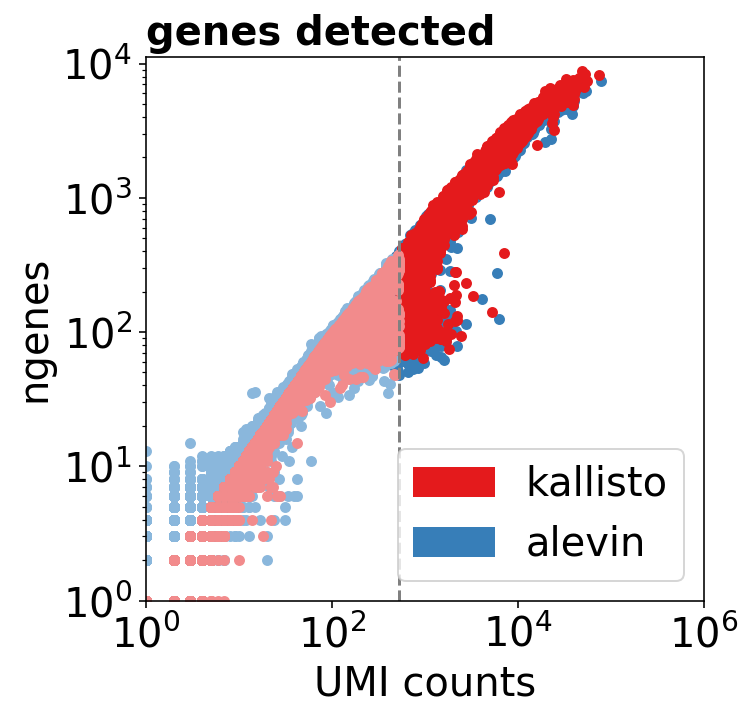

In [311]:
fig, ax = plt.subplots(figsize=(5,5))

x = kb_common.obs['counts'].values
y = kb_common.obs['ngenes'].values

xx = x[cutoff_mask]
yy = y[cutoff_mask]
ax.scatter(xx,yy, alpha =alpha, s=markersize, label='kallisto', color=kallisto_color)

xx = x[~cutoff_mask]
yy = y[~cutoff_mask]
ax.scatter(xx,yy, alpha = alpha, s=markersize, color=adjust_lightness(kallisto_color))

ax.axvline(x=cutoff, color="grey", linestyle="--")



x = alevin_common.obs['counts'].values
y = alevin_common.obs['ngenes'].values

xx = x[cutoff_mask]
yy = y[cutoff_mask]
ax.scatter(xx,yy, alpha =alpha, s=markersize, label='alevin', color=alevin_color, zorder = -1)

xx = x[~cutoff_mask]
yy = y[~cutoff_mask]
ax.scatter(xx,yy, alpha = alpha, s=markersize, color=adjust_lightness(alevin_color), zorder=-1)

ax.set(**{
    'xscale': 'log',
    'yscale': 'log',
    'xlim': (1, xmax),
    'ylim': (1),
    'xlabel': 'UMI counts',
    'ylabel': 'ngenes'
})

A_patch = mpatches.Patch(color=kallisto_color, label="kallisto")
B_patch = mpatches.Patch(color=alevin_color, label="alevin")
ax.legend(handles=[A_patch, B_patch], loc="lower right")

ax.set_title('genes detected', fontweight='bold', fontsize = fsize, loc = 'left' )


fig.show()

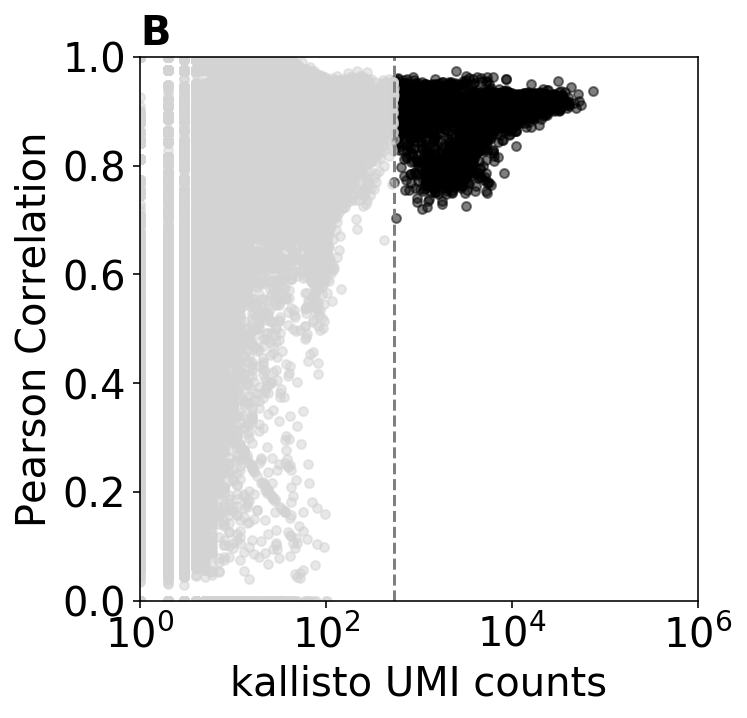

In [313]:
fig, ax = plt.subplots(figsize=(5,5))

x = kb_common.obs['counts'].values
y = cc_raw

xx = x[cutoff_mask]
yy = y[cutoff_mask]
ax.scatter(xx,yy, s=markersize, alpha=alpha-0.5, color="k")

xx = x[~cutoff_mask]
yy = y[~cutoff_mask]
ax.scatter(xx,yy, s=markersize, alpha=alpha-0.5, color="lightgray")

ax.axvline(x=cutoff, color="grey", linestyle="--")

ax.set(**{
    'xscale': 'log',
    "xlim": (1, xmax),
    'ylim': (0,1),
    'xlabel': 'kallisto UMI counts',
    'ylabel': 'Pearson Correlation'
})

ax.set_title('B', fontweight='bold', fontsize = fsize, loc = 'left' )


fig.show()

In [184]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def make_hist(A, B, orientation="vertical", ax=None):
    hist, concat_bins = np.histogram(np.concatenate((A,B)), bins='auto')
    hist, A_bins =  np.histogram(A, bins='auto')
    hist, B_bins =  np.histogram(B, bins='auto')

    best_bins = min([A_bins,concat_bins,B_bins], key=len) # may need to change to max

    ax.hist(A, bins=best_bins, orientation=orientation, color=kallisto_color, label="kallisto", alpha=1)
    ax.hist(B, bins=best_bins, orientation=orientation, color=alevin_color, label="alevin", alpha=1)
    return ax

def make_scatter_hist(dist_AA, dist_BB, dist_AB, dist_BA, ax=None):
    x = dist_AA
    y = dist_AB

    xx = dist_BA
    yy = dist_BB

    # the scatter plot:
    ax.scatter(x, y, label="kallisto", color=kallisto_color)
    ax.scatter(xx, yy, label="alevin", color=alevin_color)
    ax.set_aspect(1.)

    # create new axes on the right and on the top of the current axes
    # The first argument of the new_vertical(new_horizontal) method is
    # the height (width) of the axes to be created in inches.
    divider = make_axes_locatable(ax)
    axHistx = divider.append_axes("top", 1.5, pad=0.075, sharex=ax)
    axHisty = divider.append_axes("right", 1.5, pad=0.075, sharey=ax)

    # make some labels invisible
    axHistx.xaxis.set_tick_params(labelbottom=False)
    axHisty.yaxis.set_tick_params(labelleft=False)


    ## Right histogram,  cellranger-cellranger, kallisto-cellranger,
    axHisty = make_hist(y, yy, orientation="horizontal", ax=axHisty)

    # kallisto-kallisto, cellranger-kallisto
    axHistx = make_hist(x, xx, orientation="vertical", ax=axHistx)


    # the xaxis of axHistx and yaxis of axHisty are shared with axScatter,
    # thus there is no need to manually adjust the xlim and ylim of these
    # axis.
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.set_xlabel("$\ell_1$ to nearest kallisto", fontsize=fsize)
    ax.set_ylabel("$\ell_1$ to nearest alevin", fontsize=fsize)
    axHistx.set_ylabel("Barcode counts", fontsize=fsize-8)
    axHisty.set_xlabel("Barcode counts", fontsize=fsize-8)

    axHistx.legend(fontsize=fsize-5, loc="upper right")
    return axHistx

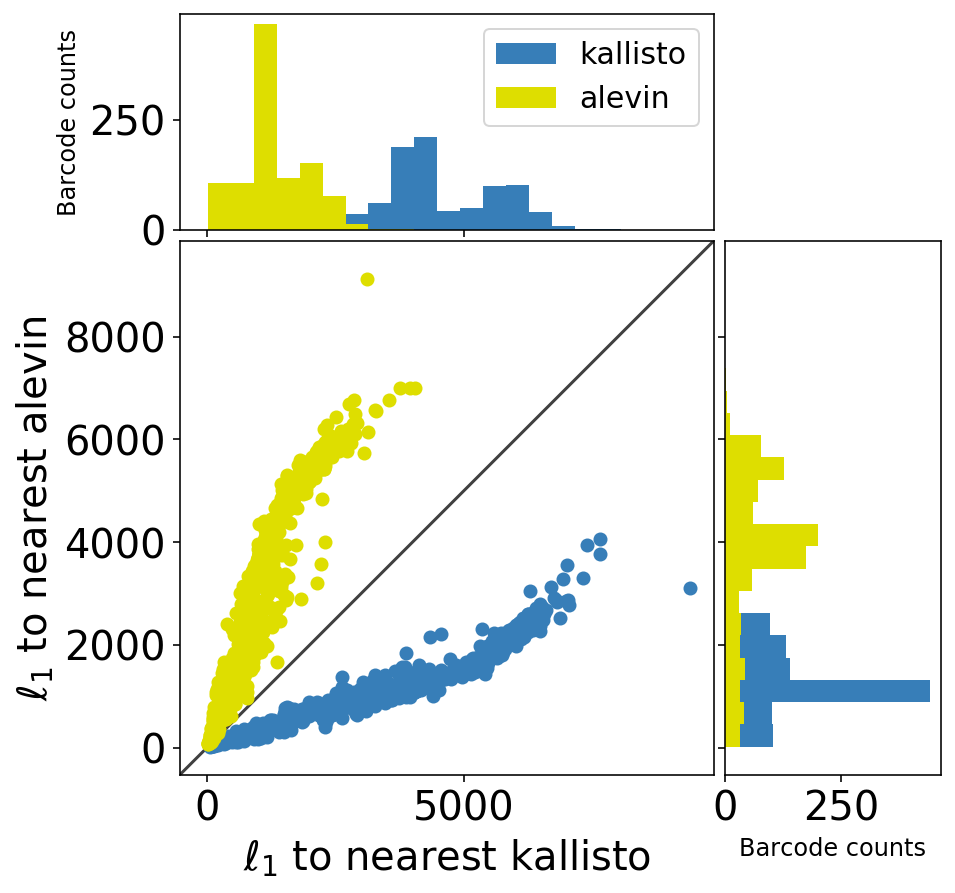

In [185]:
fig, ax = plt.subplots(figsize=(7,7))

make_scatter_hist(dist_AA, dist_BB, dist_AB, dist_BA, ax=ax)

fig.show()

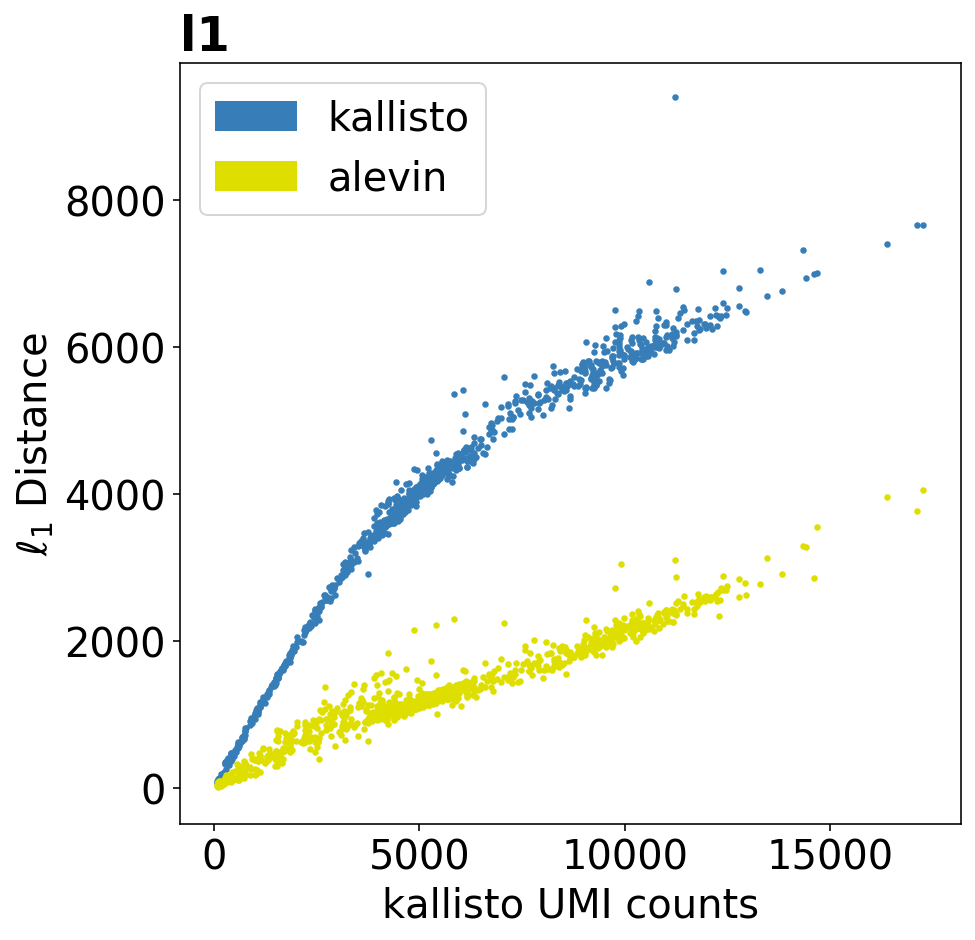

In [225]:
fig, ax = plt.subplots(figsize=(7,7))

title = "l1"

cnts = nd(kb_common_cr.layers["log1p"].sum(1))

ax.scatter(cnts, dist_AA, color=kallisto_color, alpha=alpha, label="kallisto", s=markersize)
ax.scatter(cnts, dist_AB, color=alevin_color, alpha=alpha, label="alevin", s=markersize)

ax.set(**{
    "xlabel": "kallisto UMI counts",
    "ylabel": "$\ell_1$ Distance"
})

ax.set_title(title, fontweight='bold', loc = 'left' )

A_patch = mpatches.Patch(color=kallisto_color, label="kallisto")
B_patch = mpatches.Patch(color=alevin_color, label="alevin")
ax.legend(handles=[A_patch, B_patch], loc="upper left")


fig.show()

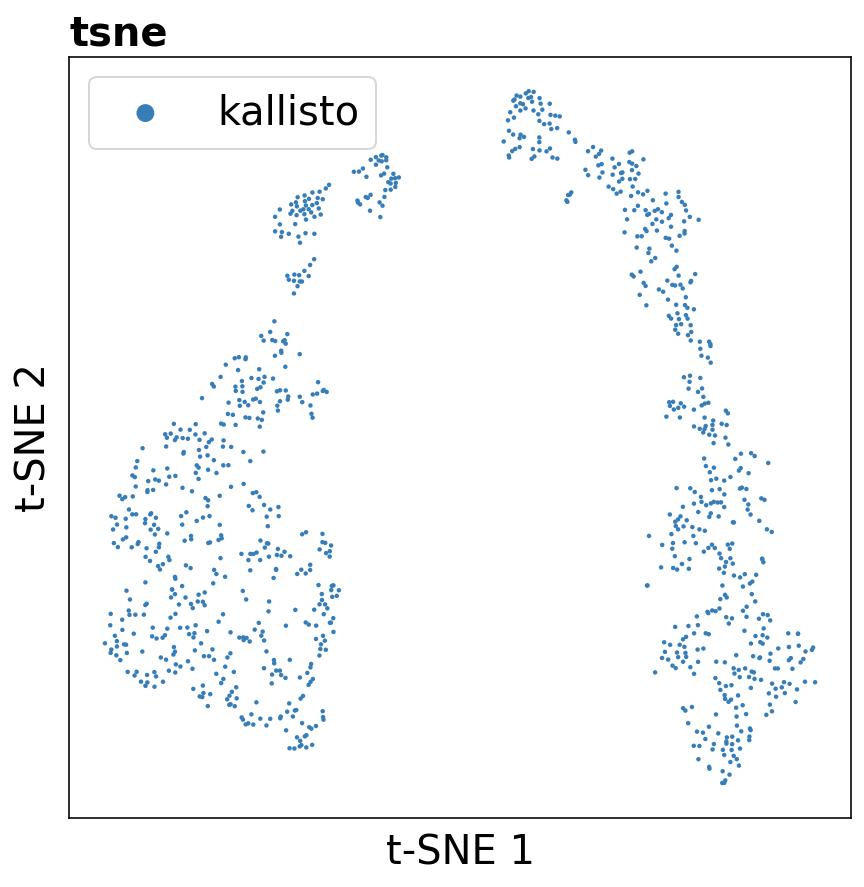

In [226]:
fig, ax = plt.subplots(figsize=(7,7))

title = "tsne"

label = "kallisto"
color = kallisto_color
x = kb_common_cr.obsm['TSNE'][:,0]
y = kb_common_cr.obsm['TSNE'][:,1]

ax.scatter(x, y, s =markersize, c = color, alpha = 1, edgecolors = 'none', label = label)

ax.set(**{
    "xlabel": "t-SNE 1",
    "ylabel": "t-SNE 2",
    "xticklabels": [],
    "yticklabels": [],
    
})

ax.set_title(title, fontweight='bold', fontsize = fsize, loc = 'left' )
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.legend(fontsize=fsize, markerscale=4, loc="upper left")

fig.show()

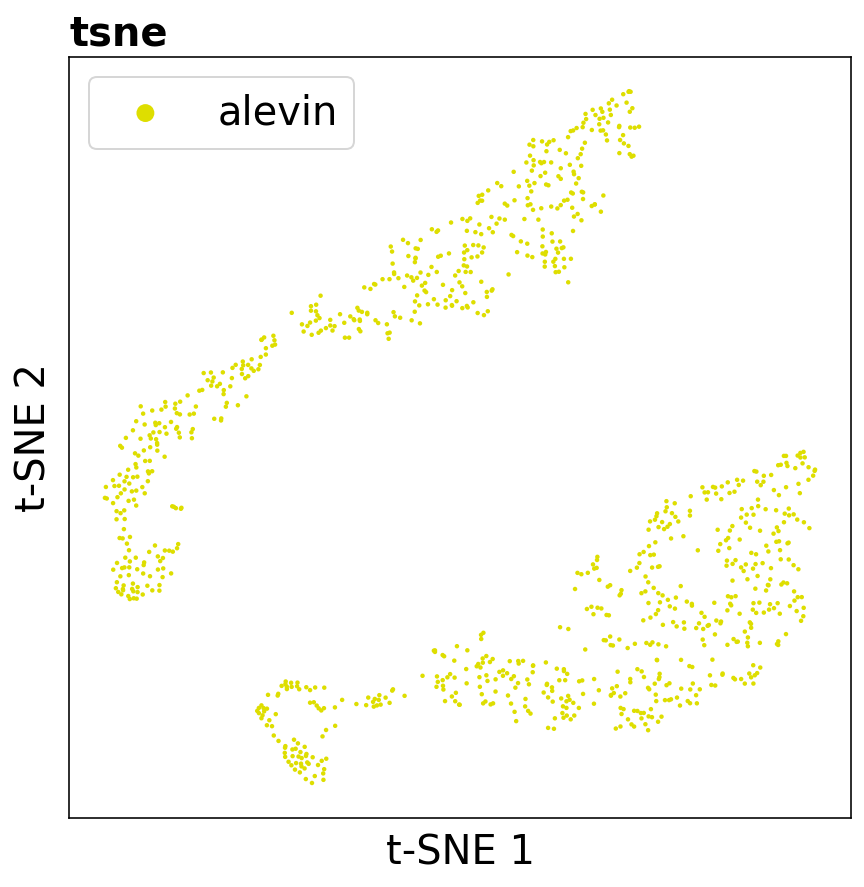

In [227]:
fig, ax = plt.subplots(figsize=(7,7))

title = "tsne"

label = "alevin"
color = alevin_color

x = alevin_common_cr.obsm['TSNE'][:,0]
y = alevin_common_cr.obsm['TSNE'][:,1]

ax.scatter(x, y, s =markersize, c = color, alpha = 1, edgecolors = 'none', label = label)

ax.set(**{
    "xlabel": "t-SNE 1",
    "ylabel": "t-SNE 2",
    "xticklabels": [],
    "yticklabels": [],
    
})

ax.set_title(title, fontweight='bold', fontsize = fsize, loc = 'left' )
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.legend(fontsize=fsize, markerscale=4, loc="upper left")

fig.show()

In [189]:
def _plt_color(lst):
    cols=[]
    for l in lst:
        if l>0.25 or l<-0.25:
            cols.append("red")
        elif l<=0.25 and l>=-0.25:
            cols.append('black')
    return cols

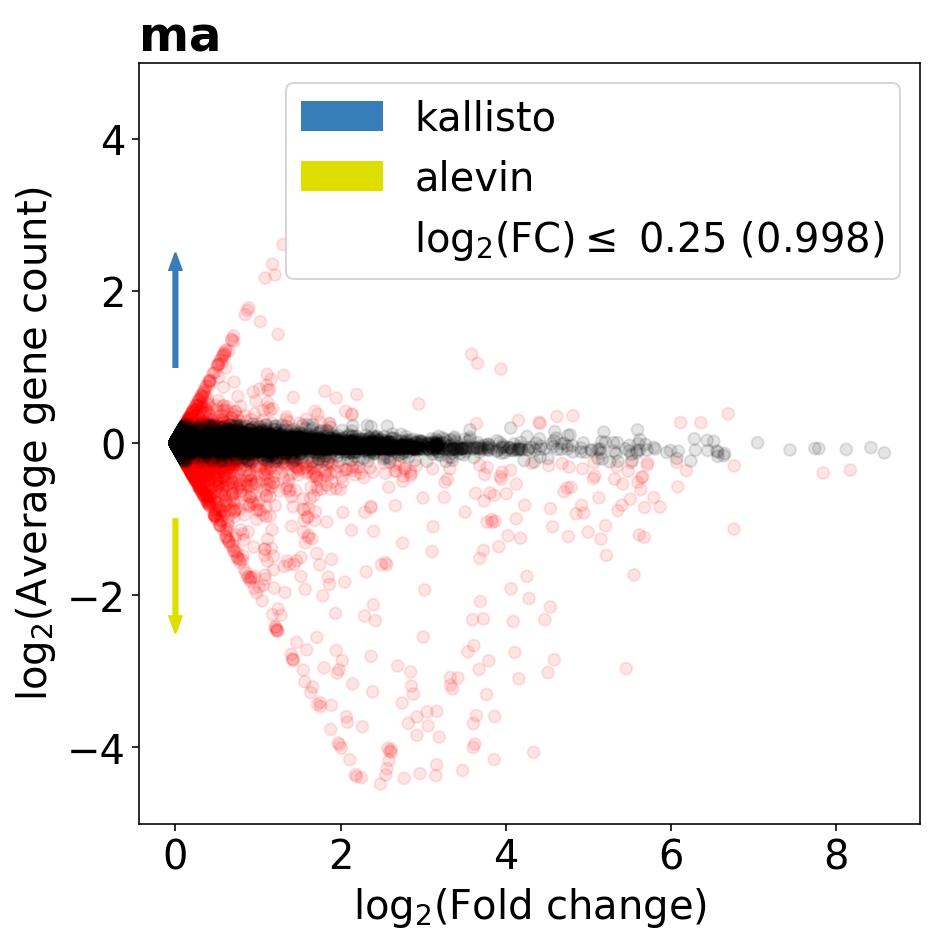

In [190]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(7,7))

title = "ma"

cols = _plt_color(M_AB)
ax.scatter(A_AB, M_AB, alpha=0.1, c=cols)

ax.set(**{
    "xlabel": "log$_2$(Fold change)",
    "ylabel": "log$_2$(Average gene count)",
    "ylim": (-5, 5)
})


ax.set_title(title, fontweight='bold', loc = 'left' )

A_patch = mpatches.Patch(color=kallisto_color, label="kallisto")
B_patch = mpatches.Patch(color=alevin_color, label="alevin")
same = mpatches.Patch(color='white', label='log$_2$(FC)$\leq$ 0.25 ({:.3f})'.format(M_AB[M_AB<=0.25].shape[0]/M_AB.shape[0]))
ax.arrow(0, 1, 0, 1.5, length_includes_head=True, width=.05, color=kallisto_color)
ax.arrow(0, -1, 0, -1.5, length_includes_head=True, width=.05, color=alevin_color)
ax.legend(handles=[A_patch, B_patch, same], fontsize=fsize, loc="upper right")

fig.show()

# All together

In [234]:
import matplotlib.patches as mpatches

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

from mpl_toolkits.axes_grid1 import make_axes_locatable

def make_hist(A, B, orientation="vertical", ax=None):
    hist, concat_bins = np.histogram(np.concatenate((A,B)), bins='auto')
    hist, A_bins =  np.histogram(A, bins='auto')
    hist, B_bins =  np.histogram(B, bins='auto')

    best_bins = min([A_bins,concat_bins,B_bins], key=len) # may need to change to max

    ax.hist(A, bins=best_bins, orientation=orientation, color=kallisto_color, label="kallisto", alpha=1)
    ax.hist(B, bins=best_bins, orientation=orientation, color=alevin_color, label="alevin", alpha=1)
    return ax

def make_scatter_hist(dist_AA, dist_BB, dist_AB, dist_BA, ax=None):
    x = dist_AA
    y = dist_AB

    xx = dist_BA
    yy = dist_BB

    # the scatter plot:
    ax.scatter(x, y, label="kallisto", color=kallisto_color, s=markersize)
    ax.scatter(xx, yy, label="alevin", color=alevin_color, s=markersize)
    ax.set_aspect(1.)

    # create new axes on the right and on the top of the current axes
    # The first argument of the new_vertical(new_horizontal) method is
    # the height (width) of the axes to be created in inches.
    divider = make_axes_locatable(ax)
    axHistx = divider.append_axes("top", 1.5, pad=0.075, sharex=ax)
    axHisty = divider.append_axes("right", 1.5, pad=0.075, sharey=ax)

    # make some labels invisible
    axHistx.xaxis.set_tick_params(labelbottom=False)
    axHisty.yaxis.set_tick_params(labelleft=False)


    ## Right histogram,  cellranger-cellranger, kallisto-cellranger,
    axHisty = make_hist(y, yy, orientation="horizontal", ax=axHisty)

    # kallisto-kallisto, cellranger-kallisto
    axHistx = make_hist(x, xx, orientation="vertical", ax=axHistx)


    # the xaxis of axHistx and yaxis of axHisty are shared with axScatter,
    # thus there is no need to manually adjust the xlim and ylim of these
    # axis.
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.set_xlabel("$\ell_1$ to nearest kallisto", fontsize=fsize)
    ax.set_ylabel("$\ell_1$ to nearest alevin", fontsize=fsize)
    axHistx.set_ylabel("Barcode counts", fontsize=fsize-8)
    axHisty.set_xlabel("Barcode counts", fontsize=fsize-8)

    axHistx.set_title("l1", fontweight='bold', loc = 'left' )

    axHistx.legend(fontsize=fsize-5, loc="upper right")
    return axHistx


In [256]:
markersize = 20
alpha=1
linewidth=5
xmax = 10**6

kallisto_color = "#377eb8"
alevin_color = "#dede00"

kallisto_color = "#e41a1c"
alevin_color = '#377eb8'

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
dataset_name = ds

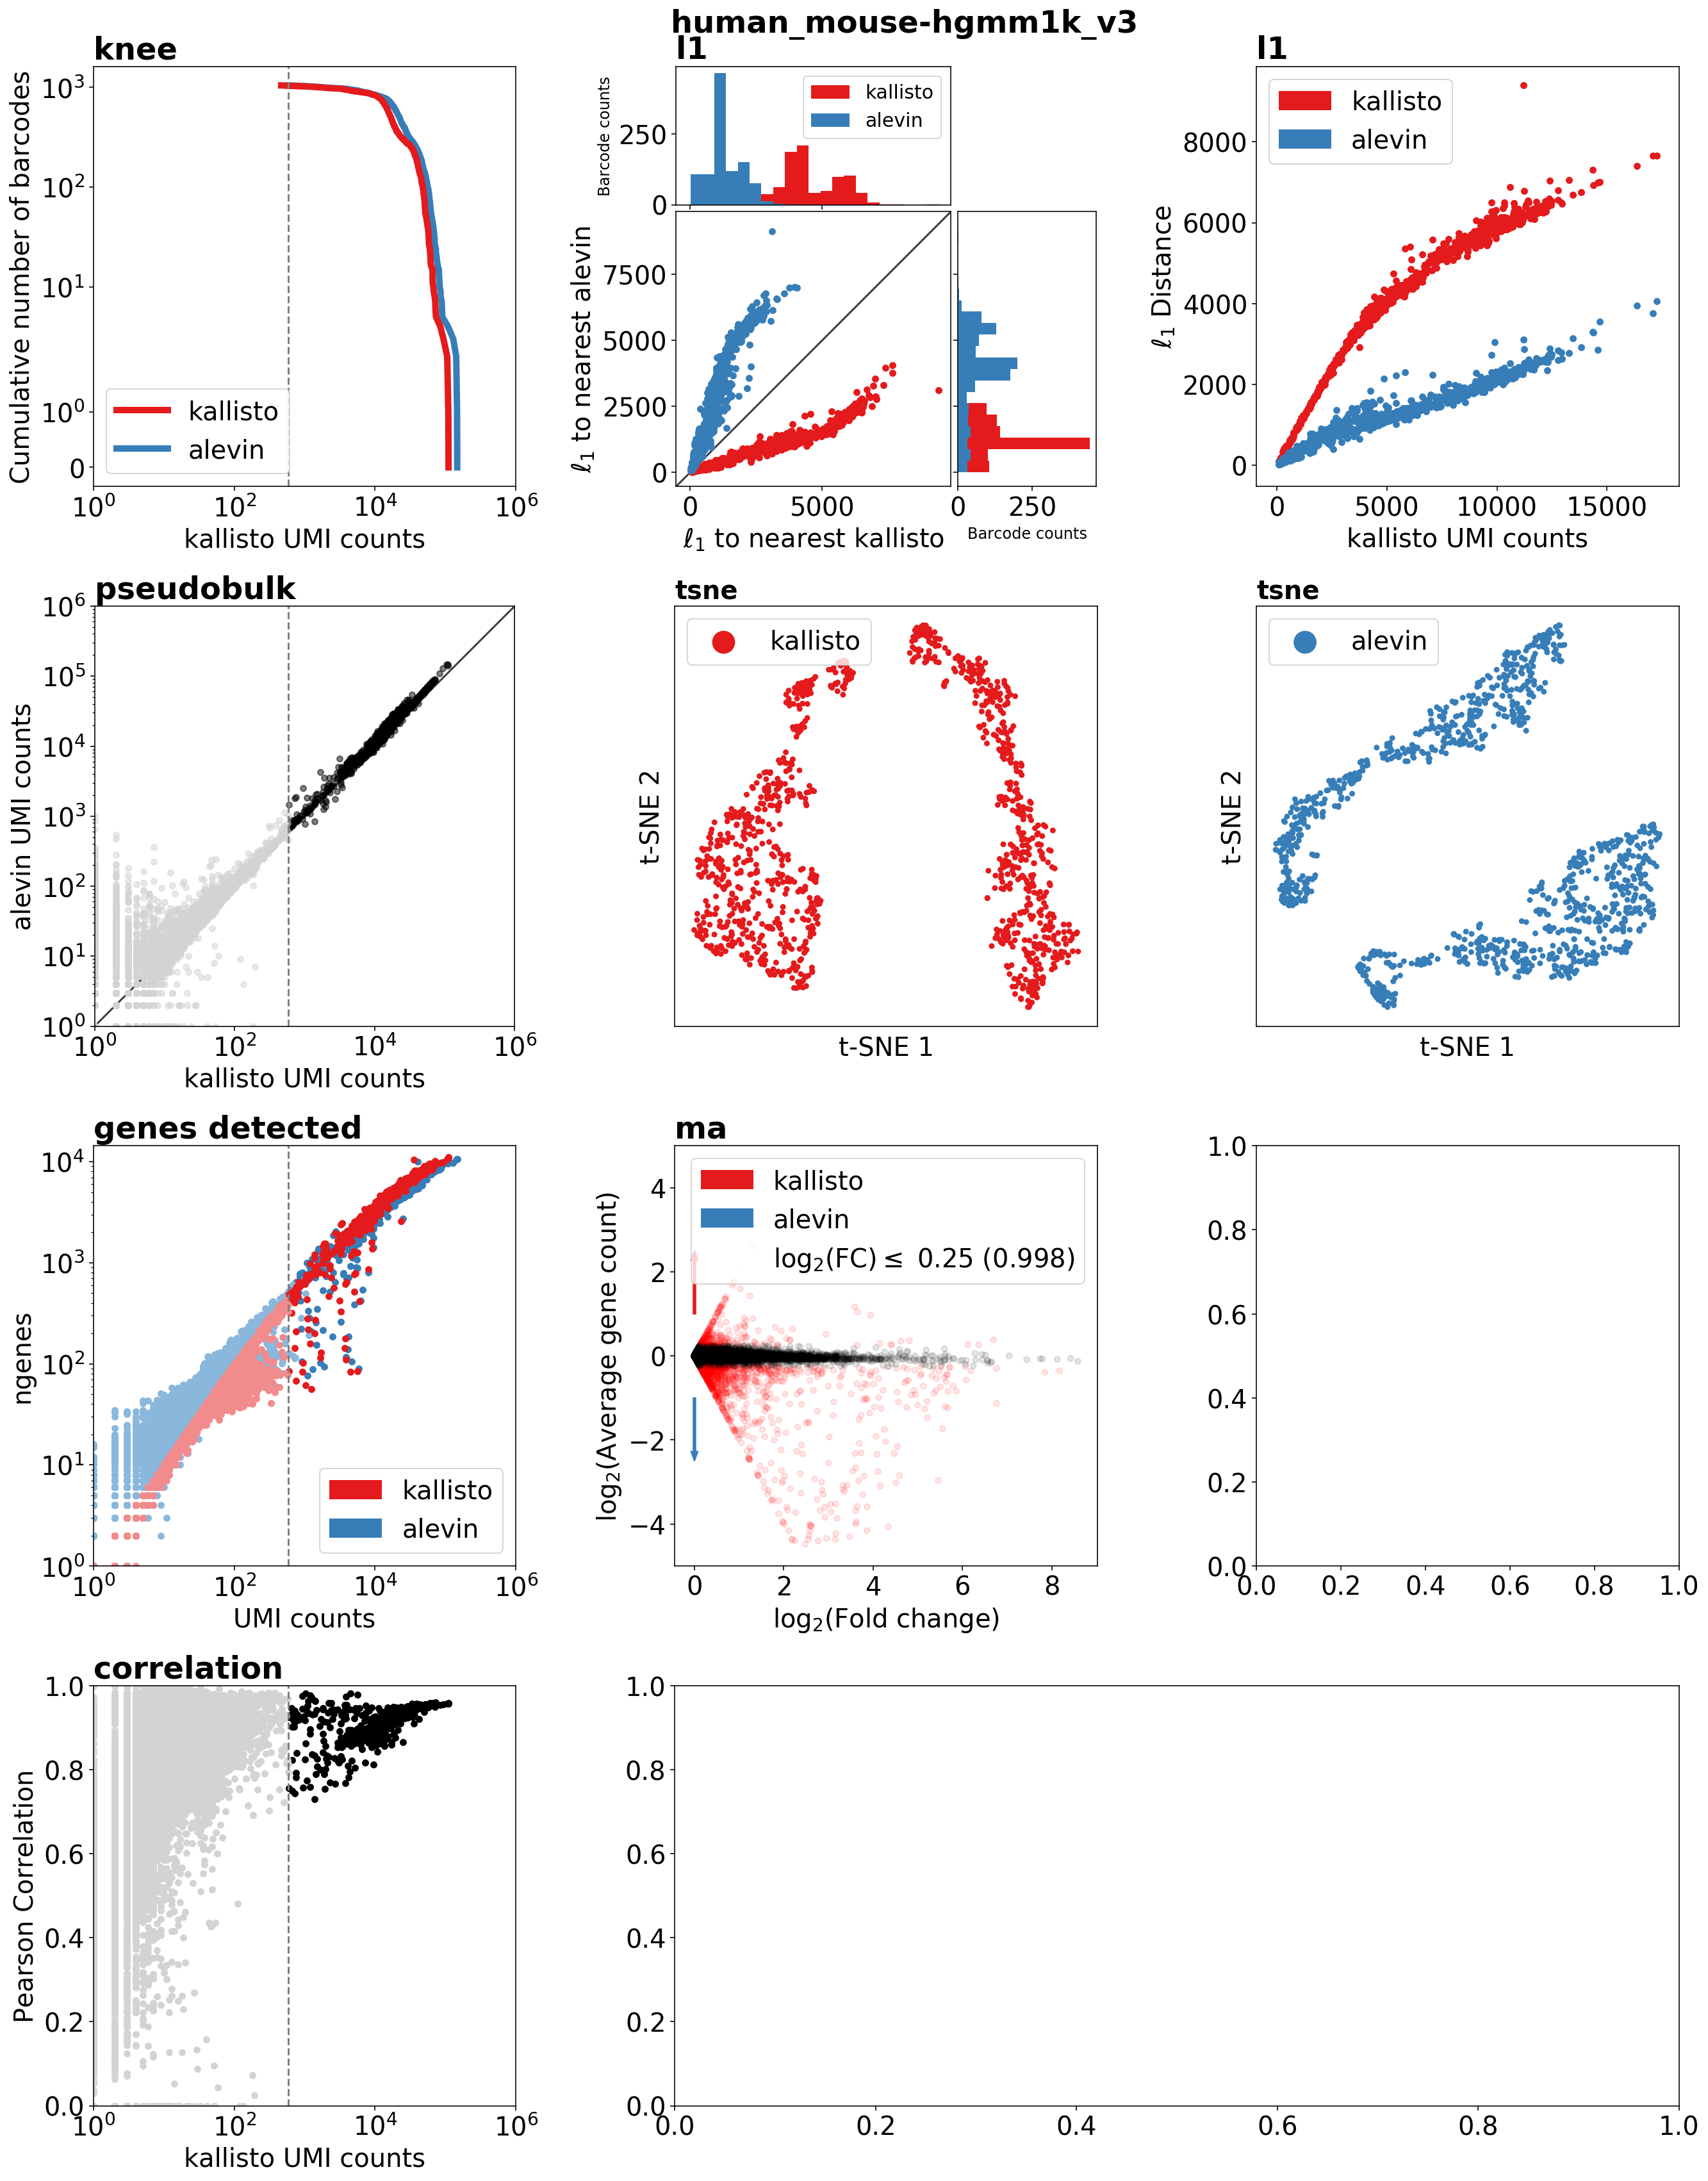

In [257]:
fig = plt.figure(figsize=(25, 25),constrained_layout=False)
st = fig.suptitle(dataset_name, fontweight='bold', x=0.4)
gs = fig.add_gridspec(8, 4)

ax_a = fig.add_subplot(gs[0:2, 0])
ax_b = fig.add_subplot(gs[2:4, 0])
ax_c = fig.add_subplot(gs[4:6, 0])
ax_d = fig.add_subplot(gs[6:8, 0])

ax_e_left   = fig.add_subplot(gs[0:2, 1])
ax_e_right  = fig.add_subplot(gs[0:2, 2])

ax_f_left   = fig.add_subplot(gs[2:4, 1])
ax_f_right  = fig.add_subplot(gs[2:4, 2])
ax_g_left   = fig.add_subplot(gs[4:6, 1])
ax_g_right  = fig.add_subplot(gs[4:6, 2])

ax_h        = fig.add_subplot(gs[6:8, 1:3])


############################################################################## KNEE plot
ax = ax_a

title = "knee"

x = np.sort(nd(kb_common_cr.X.sum(axis=1)))[::-1]
y = np.arange(x.shape[0])

ax.plot(x, y, color=kallisto_color, label="kallisto", linewidth=linewidth)

# ## Alevin
x = np.sort(nd(alevin_common_cr.X.sum(axis=1)))[::-1]
y = np.arange(x.shape[0])

cutoff = min(x)

ax.axvline(x=cutoff, color="grey", linestyle="--")

ax.plot(x, y, color = alevin_color, label="alevin", linewidth=linewidth, zorder=-1)

ax.set(**{
    'xscale': 'log',
    'xlim': (1, xmax),
    'yscale': 'symlog',
    'xlabel': "kallisto UMI counts",
    'ylabel': "Cumulative number of barcodes"
 })
ax.set_title(title, fontweight='bold', loc = 'left' )
ax.legend()

############################################################################## PSEUDOBULK
ax = ax_b

title = "pseudobulk"

x = kb_common.obs['counts'].values
y = alevin_common.obs['counts'].values

cutoff_mask = x>=cutoff

xx = x[cutoff_mask]
yy = y[cutoff_mask]
ax.scatter(xx,yy, alpha = alpha-0.5, s=markersize, color="k")

xx = x[~cutoff_mask]
yy = y[~cutoff_mask]
ax.scatter(xx,yy, alpha = alpha-0.5, s=markersize, color="lightgrey")


ax.axvline(x=cutoff, color="grey", linestyle="--")


ax.set(**{
    "xlim": (1, xmax),
     'xscale': 'log',
     'yscale': 'log',
    'xlabel': 'kallisto UMI counts',
    'ylabel': 'alevin UMI counts'
})
yex(ax)

ax.set_title(title, fontweight='bold', loc = 'left' )

############################################################################## GENES DETECTED
ax = ax_c

title = "genes detected"

x = kb_common.obs['counts'].values
y = kb_common.obs['ngenes'].values

xx = x[cutoff_mask]
yy = y[cutoff_mask]
ax.scatter(xx,yy, alpha =alpha, s=markersize, label='kallisto', color=kallisto_color)

xx = x[~cutoff_mask]
yy = y[~cutoff_mask]
ax.scatter(xx,yy, alpha = alpha, s=markersize, color=adjust_lightness(kallisto_color))

ax.axvline(x=cutoff, color="grey", linestyle="--")

x = alevin_common.obs['counts'].values
y = alevin_common.obs['ngenes'].values

xx = x[cutoff_mask]
yy = y[cutoff_mask]
ax.scatter(xx,yy, alpha =alpha, s=markersize, label='alevin', color=alevin_color, zorder = -1)

xx = x[~cutoff_mask]
yy = y[~cutoff_mask]
ax.scatter(xx,yy, alpha = alpha, s=markersize, color=adjust_lightness(alevin_color), zorder=-1)

ax.set(**{
    'xscale': 'log',
    'yscale': 'log',
    'xlim': (1, xmax),
    'ylim': (1),
    'xlabel': 'UMI counts',
    'ylabel': 'ngenes'
})

A_patch = mpatches.Patch(color=kallisto_color, label="kallisto")
B_patch = mpatches.Patch(color=alevin_color, label="alevin")
ax.legend(handles=[A_patch, B_patch], loc="lower right")

ax.set_title(title, fontweight='bold', loc = 'left' )

############################################################################## CORRELATION
ax = ax_d

title = "correlation"

x = kb_common.obs['counts'].values
y = cc_raw

xx = x[cutoff_mask]
yy = y[cutoff_mask]
ax.scatter(xx,yy, s=markersize, alpha=alpha, color="k")

xx = x[~cutoff_mask]
yy = y[~cutoff_mask]
ax.scatter(xx,yy, s=markersize, alpha=alpha, color="lightgray")

ax.axvline(x=cutoff, color="grey", linestyle="--")

ax.set(**{
    'xscale': 'log',
    "xlim": (1, xmax),
    'ylim': (0,1),
    'xlabel': 'kallisto UMI counts',
    'ylabel': 'Pearson Correlation'
})

ax.set_title(title, fontweight='bold', loc = 'left' )

############################################################################## l1
ax = ax_e_left

title = "l1"

make_scatter_hist(dist_AA, dist_BB, dist_AB, dist_BA, ax=ax)

ax.set_title(title, fontweight='bold', loc = 'left' )


#############
ax = ax_e_right

title = "l1"

cnts = nd(kb_common_cr.layers["log1p"].sum(1))

ax.scatter(cnts, dist_AA, color=kallisto_color, alpha=alpha, label="kallisto", s=markersize)
ax.scatter(cnts, dist_AB, color=alevin_color, alpha=alpha, label="alevin", s=markersize)

ax.set(**{
    "xlabel": "kallisto UMI counts",
    "ylabel": "$\ell_1$ Distance"
})

ax.set_title(title, fontweight='bold', loc = 'left' )

A_patch = mpatches.Patch(color=kallisto_color, label="kallisto")
B_patch = mpatches.Patch(color=alevin_color, label="alevin")
ax.legend(handles=[A_patch, B_patch], loc="upper left")

############################################################################## TSNE
ax = ax_f_left

title = "tsne"

label = "kallisto"
color = kallisto_color
x = kb_common_cr.obsm['TSNE'][:,0]
y = kb_common_cr.obsm['TSNE'][:,1]

ax.scatter(x, y, s =markersize, c = color, alpha = 1, edgecolors = 'none', label = label)

ax.set(**{
    "xlabel": "t-SNE 1",
    "ylabel": "t-SNE 2",
    "xticklabels": [],
    "yticklabels": [],
    
})

ax.set_title(title, fontweight='bold', fontsize = fsize, loc = 'left' )
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.legend(fontsize=fsize, markerscale=4, loc="upper left")

################
ax = ax_f_right

title = "tsne"

label = "alevin"
color = alevin_color

x = alevin_common_cr.obsm['TSNE'][:,0]
y = alevin_common_cr.obsm['TSNE'][:,1]

ax.scatter(x, y, s =markersize, c = color, alpha = 1, edgecolors = 'none', label = label)

ax.set(**{
    "xlabel": "t-SNE 1",
    "ylabel": "t-SNE 2",
    "xticklabels": [],
    "yticklabels": [],
    
})

ax.set_title(title, fontweight='bold', fontsize = fsize, loc = 'left' )
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.legend(fontsize=fsize, markerscale=4, loc="upper left")


############################################################################## MA
ax = ax_g_left

title = "ma"

cols = _plt_color(M_AB)
ax.scatter(A_AB, M_AB, alpha=0.1, c=cols, s=markersize)

ax.set(**{
    "xlabel": "log$_2$(Fold change)",
    "ylabel": "log$_2$(Average gene count)",
    "ylim": (-5, 5)
})


ax.set_title(title, fontweight='bold', loc = 'left' )

A_patch = mpatches.Patch(color=kallisto_color, label="kallisto")
B_patch = mpatches.Patch(color=alevin_color, label="alevin")
same = mpatches.Patch(color='white', label='log$_2$(FC)$\leq$ 0.25 ({:.3f})'.format(M_AB[M_AB<=0.25].shape[0]/M_AB.shape[0]))
ax.arrow(0, 1, 0, 1.5, length_includes_head=True, width=.05, color=kallisto_color)
ax.arrow(0, -1, 0, -1.5, length_includes_head=True, width=.05, color=alevin_color)
ax.legend(handles=[A_patch, B_patch, same], fontsize=fsize, loc="upper right")

plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.925)
fig.show()